# Prepare small dataset

In [1]:
import argparse
import os
from os.path import exists, dirname
import sys
import pandas as pd
import numpy as np
import geopandas as gpd
from copy import deepcopy
# Shim to point geoconformal -> GeoConformal
import sys, importlib
sys.modules['GeoConformal'] = importlib.import_module('geoconformal')

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import root_mean_squared_error

parent_dir = dirname(os.path.abspath(os.getcwd()))
sys.path.append(parent_dir)

from bayes.explanations import BayesLocalExplanations, explain_many
from bayes.models import *

from GeoConformalizedExplainer import GeoConformalizedExplainer

parser = argparse.ArgumentParser()
parser.add_argument("--cred_width", type=float, default=0.1)
parser.add_argument("--save_loc", type=str, required=True)
parser.add_argument("--n_top_segs", type=int, default=5)
parser.add_argument("--n_gif_images", type=int, default=20)

c:\Rena\MIT2\UROP\SCR\project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


_StoreAction(option_strings=['--n_gif_images'], dest='n_gif_images', nargs=None, const=None, default=20, type=<class 'int'>, choices=None, required=False, help=None, metavar=None, deprecated=False)

https://github.com/Ziqi-Li/geoshapley/blob/main/data/seattle_sample_3k.csv

In [2]:
# Test 500 datapoints first
data = pd.read_csv("./seattle_sample_500.csv")
data = gpd.GeoDataFrame(data, crs="EPSG:32610", geometry=gpd.points_from_xy(x=data.UTM_X, y=data.UTM_Y))
data = data.to_crs(4326) # Coordinates in lat/lon
data['lon'] = data['geometry'].get_coordinates()['x']
data['lat'] = data['geometry'].get_coordinates()['y']
data['price'] = np.power(10, data['log_price']) / 10000  # Convert to actual price in 10k USD units

y = data.price
X_coords = data[['bathrooms', 'sqft_living', 'sqft_lot', 'grade', 'condition', 'waterfront', 'view', 'age', 'lon', 'lat']]
loc = data[['lon', 'lat']]

In [3]:
""" 
Split data and train RANDOM FOREST model
80% train, 10% calibration, 10% test 
"""
X_train, X_temp, y_train, y_temp, loc_train, loc_temp = train_test_split(X_coords, y, loc, train_size=0.8, random_state=42)
X_calib, X_test, y_calib, y_test, loc_calib, loc_test = train_test_split(X_temp, y_temp, loc_temp, train_size=0.5, random_state=42)

rf = RandomForestRegressor(n_estimators = 300).fit(X_train.values,y_train.values)
print(f"Model Score: {rf.score(X_test.values, y_test.values)}")
print(f"Model RMSE: {root_mean_squared_error(y_test.values, rf.predict(X_test.values))}")

Model Score: 0.7528200225807338
Model RMSE: 16.124703245999672


In [4]:
feature_names = X_train.columns
test_index = 10

# Baseline SHAP

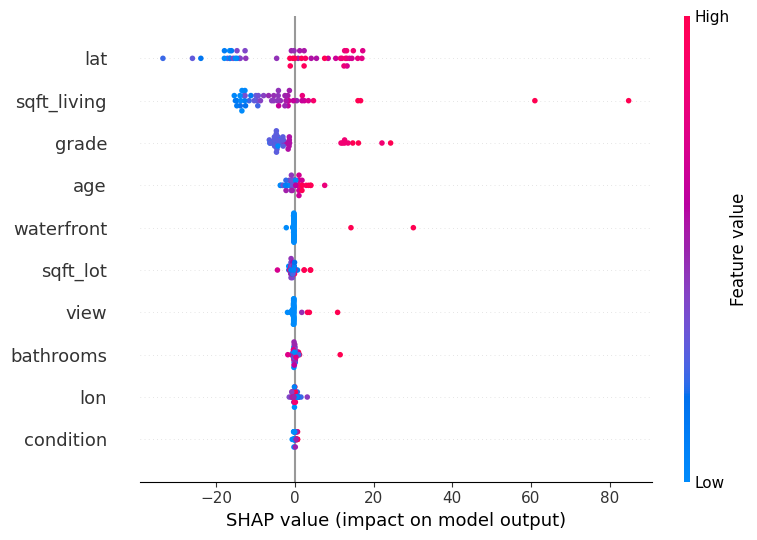

.values =
array([[-3.75059423e-01, -9.67234493e+00, -5.01247213e-01,
        -4.58511605e+00,  2.90154168e-01, -2.64607622e-01,
        -3.10264147e-01, -6.97534255e-01,  1.26348704e-01,
        -9.20860006e-01],
       [-2.26604606e-01, -1.25845132e+01, -8.43597679e-01,
        -4.03453100e+00,  8.35126226e-02, -2.75155936e-01,
        -2.43882953e-01,  1.63640859e-01, -1.45404671e-01,
        -1.41281919e+01],
       [ 4.91688625e-01, -5.41589113e+00,  1.36380832e-01,
        -1.44150394e+00,  5.86185060e-01, -2.61344238e-01,
         3.16685509e+00,  4.04046024e+00,  8.26226624e-02,
         1.70101883e+01],
       [-2.47289771e-01, -2.27841405e+00, -7.01411044e-01,
        -4.14316862e+00, -2.55554187e-01, -2.72150199e-01,
        -3.77604730e-01,  1.01317210e+00, -4.57653169e-01,
        -1.71721174e+01],
       [ 2.45178231e-02, -1.27696932e+01, -3.71762748e-01,
        -4.84101224e+00, -1.10190344e-01, -2.69564317e-01,
        -2.42373654e-01,  1.02904465e+00,  3.63070148e-01,
 

In [11]:
import shap
# Shap library handles background by itself
shap_explainer = shap.TreeExplainer(rf, feature_names=feature_names )  # Explainer gets a callable
shap_values = shap_explainer(X_test.values) # Explain model predictions on a set of samples
shap_base = shap_values.base_values[0]
shap.summary_plot(shap_values, X_test.values, show = True)

print(shap_values)

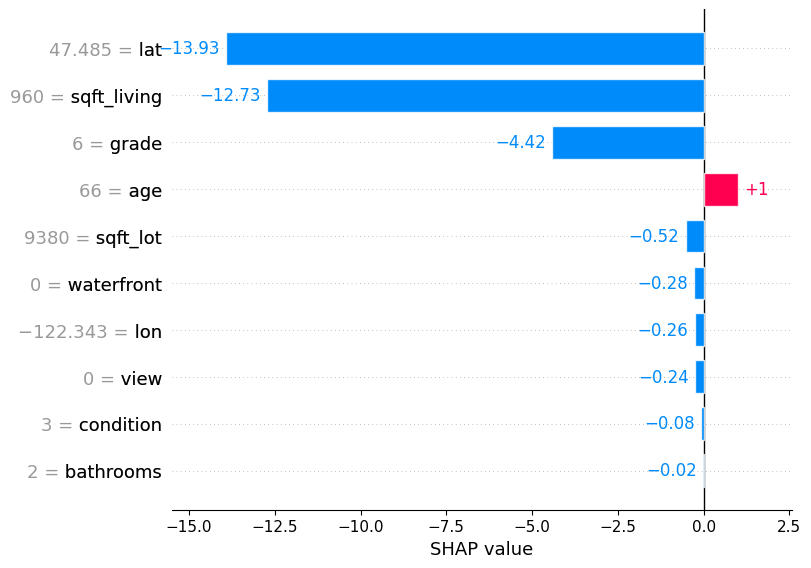

In [14]:
# Plot for just one point (compare with other models)
shap.plots.bar(shap_values[test_index])

# GeoXCP
Same impl as example python notebook

In [19]:
geo_explainer = GeoConformalizedExplainer(prediction_f=rf.predict,
                                      x_train=X_train,
                                      x_calib=X_calib,
                                      coord_calib=loc_calib.values,
                                      miscoverage_level=0.1,
                                      band_width=0.2,
                                      feature_names=feature_names)
results = geo_explainer.uncertainty_aware_explain(x_test=X_test, coord_test=loc_test)

100%|██████████| 50/50 [00:54<00:00,  1.08s/it]


Explaining Variables


In [26]:
results.accuracy_summary()

,Mean(|SHAP_value|),Uncertainty,R2,RMSE,SHAP_Var,Pred_SHAP_Var
bathrooms,0.656075,1.073176,0.266027,1.532883,3.201382,0.437402
sqft_living,8.902944,4.707884,0.915082,4.594590,248.597191,259.356183
sqft_lot,0.544811,2.540534,-3.399194,1.740146,0.688333,3.373382
grade,5.682654,4.782314,0.903043,2.438485,61.328114,65.616267
condition,0.229361,0.711831,-1.879589,0.499377,0.086602,0.196603
waterfront,1.472628,1.052091,0.747252,2.199921,19.148095,7.552247
view,0.854897,0.712074,0.826303,0.813038,3.805643,2.459310
age,1.725025,2.203866,0.722526,1.319279,6.272659,6.399923
lon,0.498293,1.869402,-0.483971,0.847465,0.483970,0.782088
lat,11.371692,8.642719,0.814157,5.625797,170.303142,164.628373


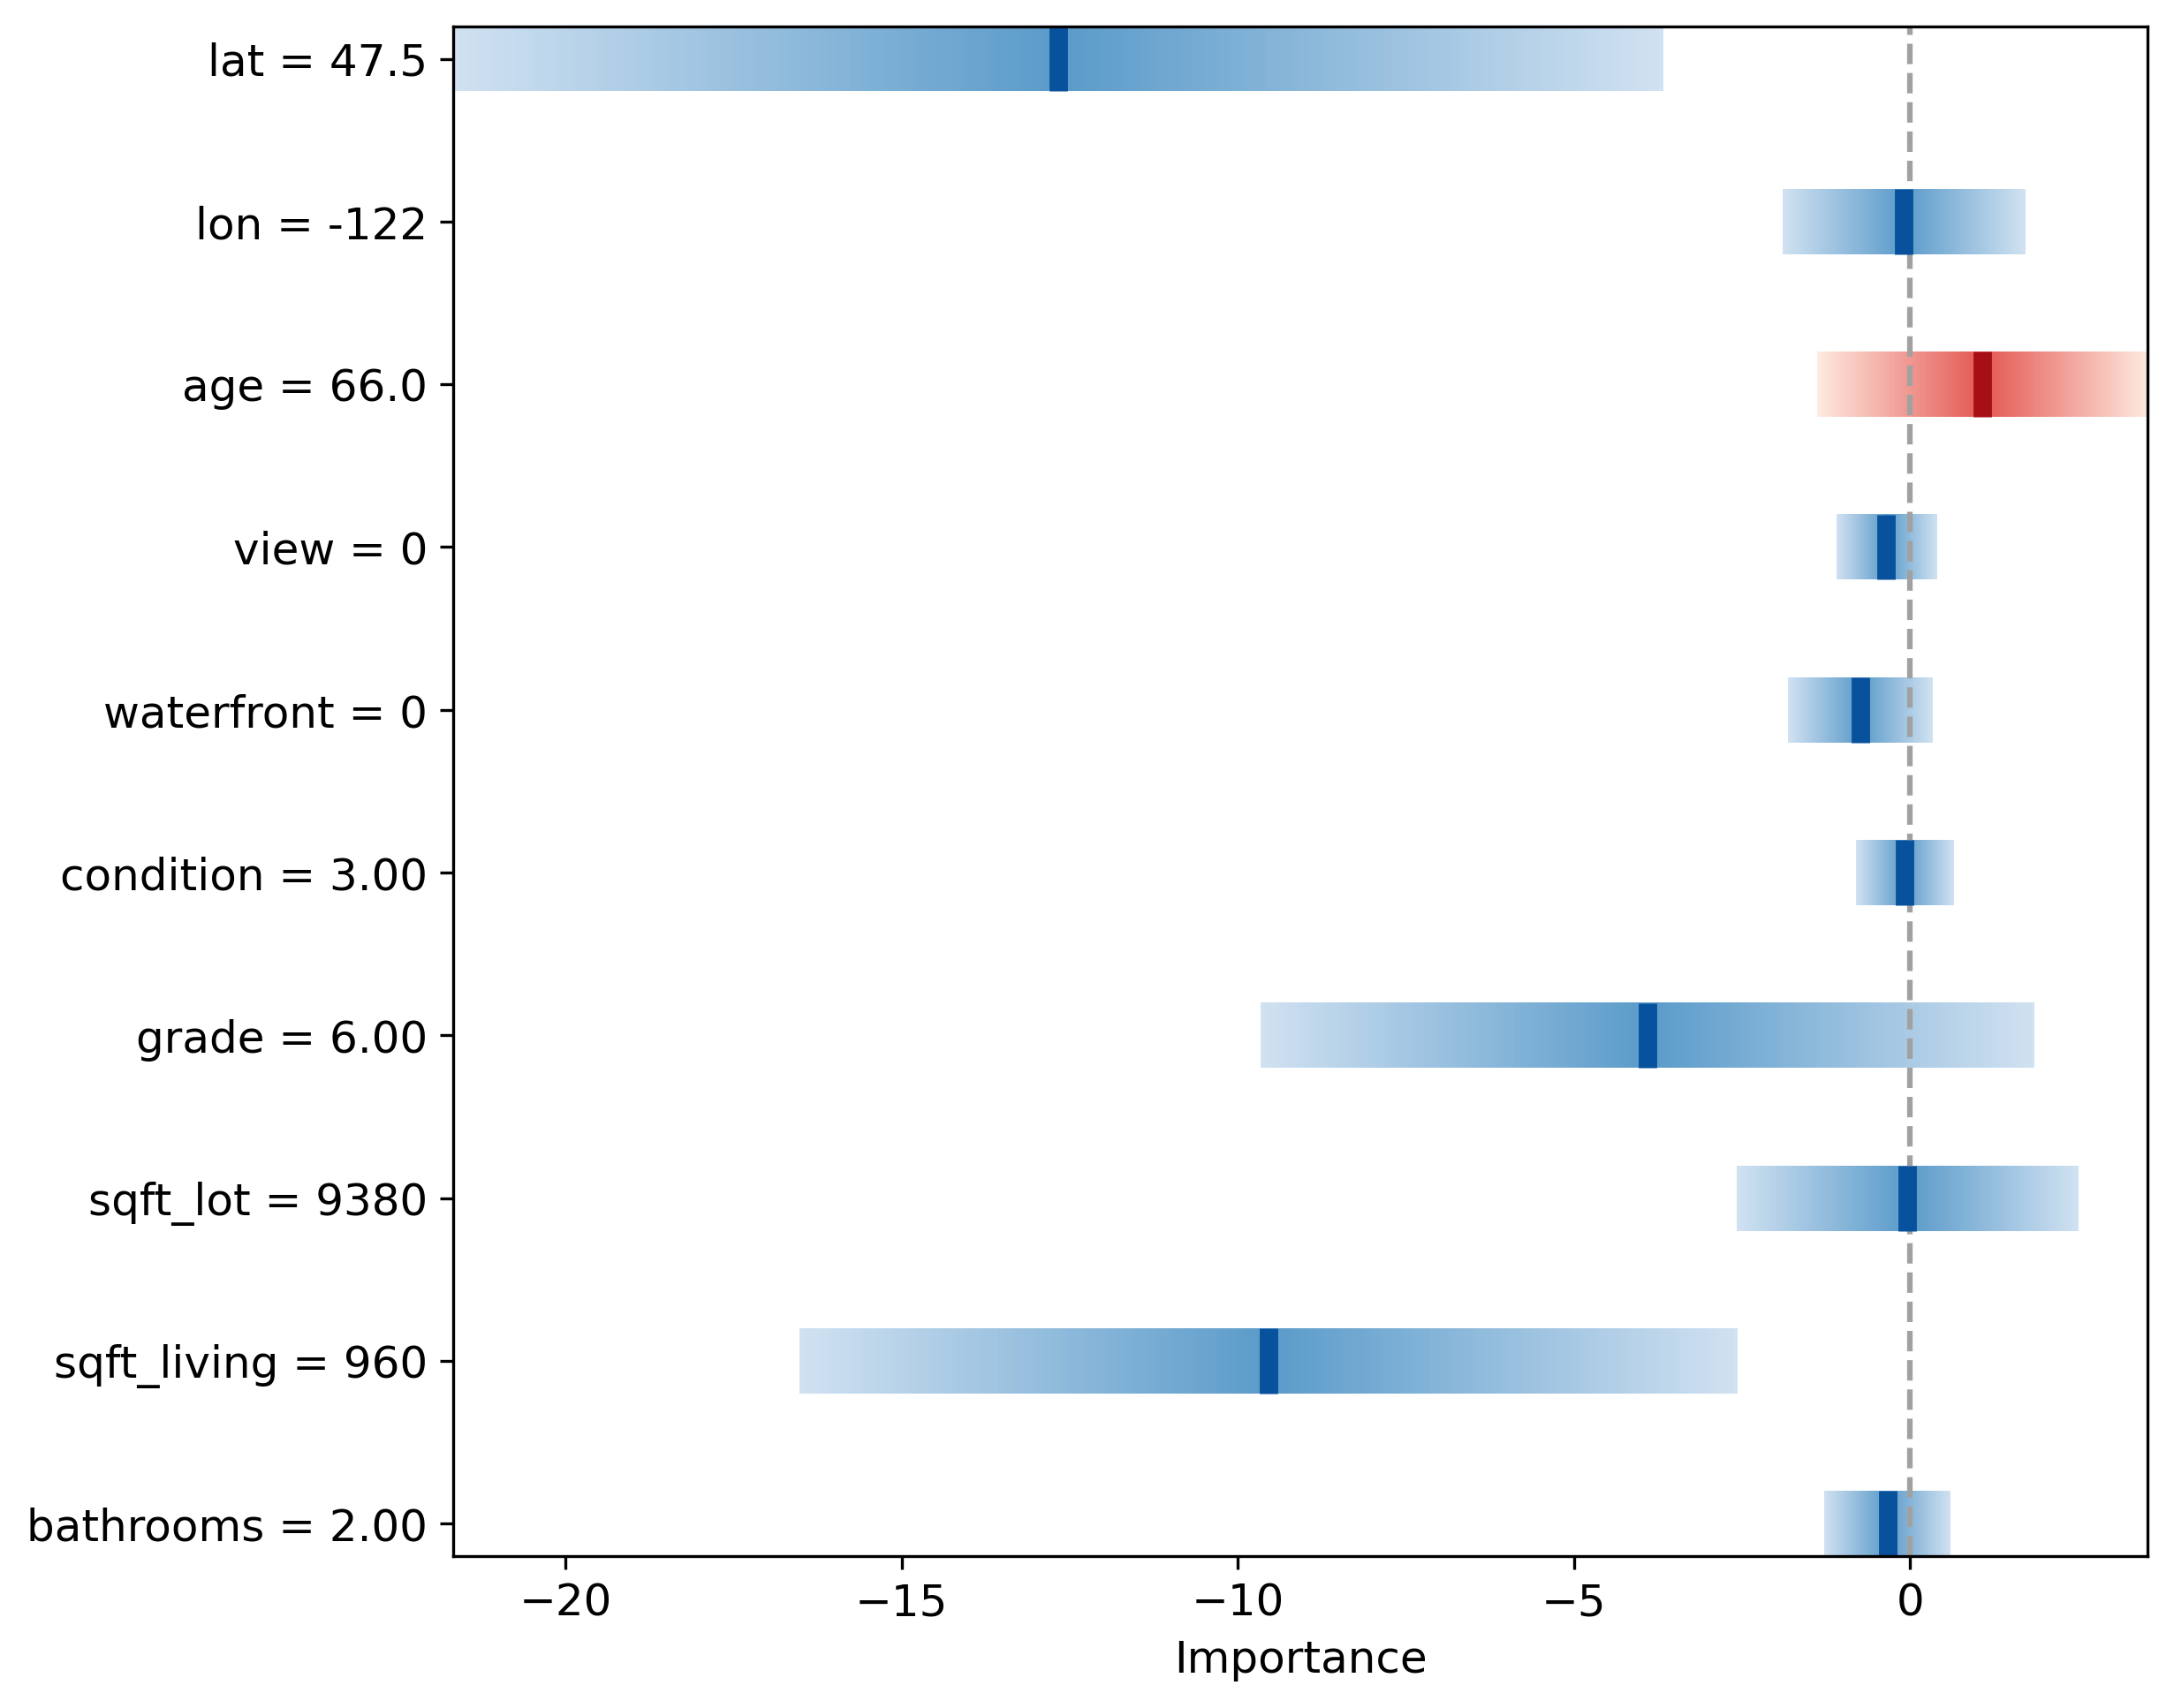

In [30]:
# Plot uncertainty for one point?
results.plot_shap_values_with_uncertainty(test_index)

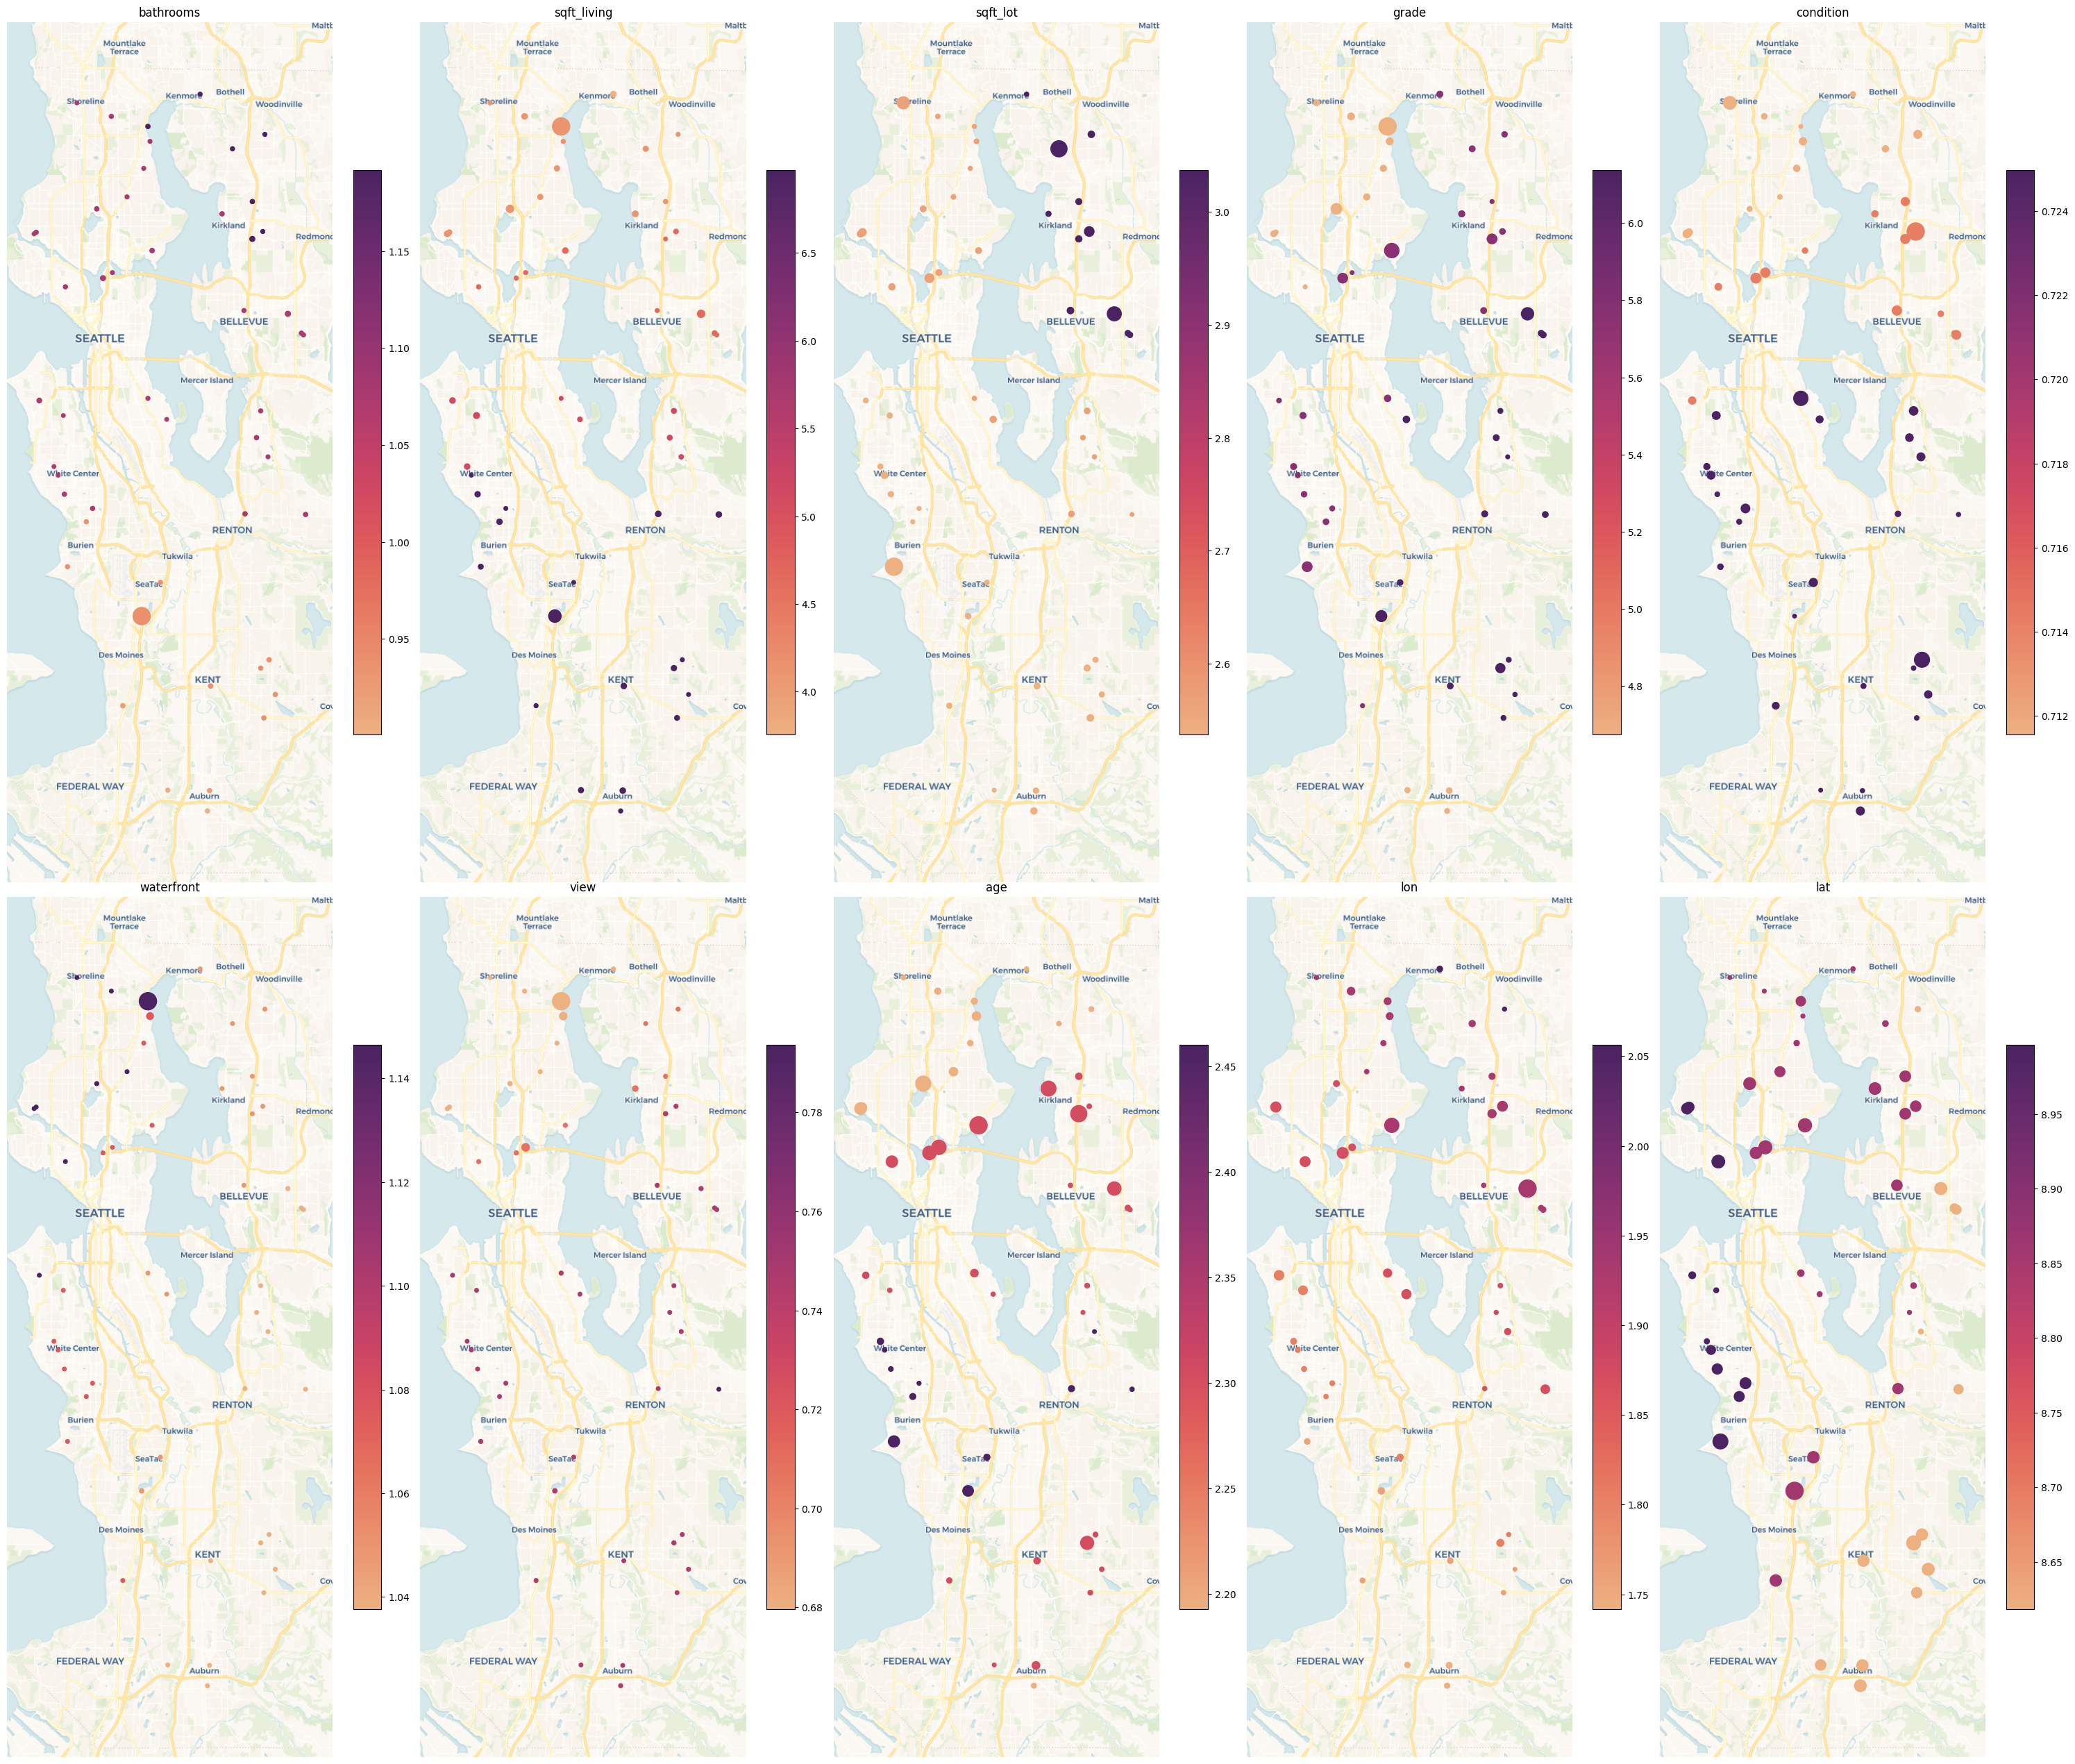

In [31]:
results.plot_geo_uncertainty(figsize=[30, 40], shrink=0.3, s_limits=(4, 18), cmap='flare')

c:\Rena\MIT2\UROP\SCR\project\.venv\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


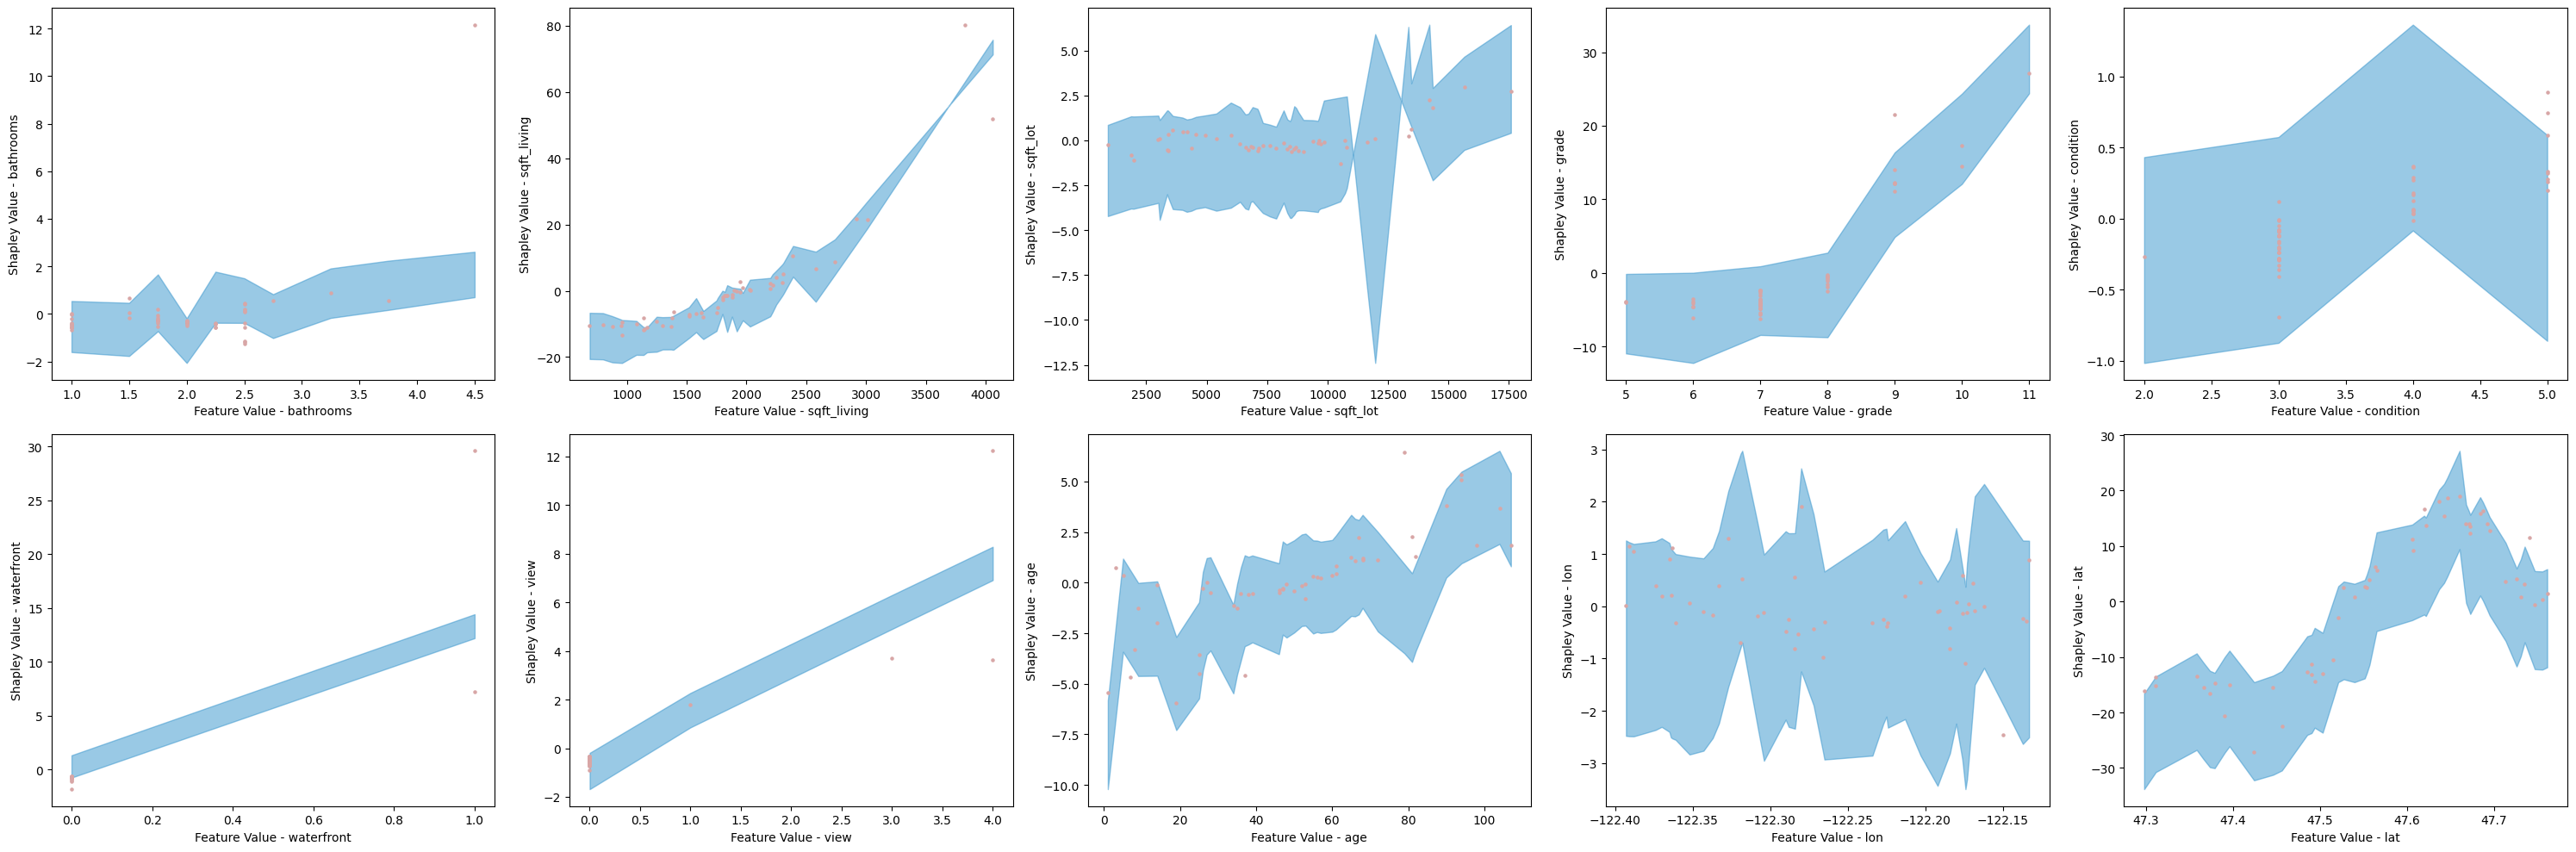

In [32]:
results.plot_partial_dependence_with_fitted_bounds(figsize=[30, 10], filename='./GeoConformalizedSHAP_PredictionInterval.pdf')

Shaded region corresponds to 90% COVERAGE

# Bootstrapping
Not implemented

# Bayes SHAP
unlike example code, does not use standard scaler

In [15]:
# Get background data
# k means
n, d = X_train.shape
n_background = min(128,n)
k = min(n_background, max(2, d*2)) # num clusters
km = KMeans(n_clusters=k, n_init=10, random_state=1).fit(X_train) # kmeans model and run actual clustering
# cluster_centers_ is ndarray of shape (k, d)
xtrain = km.cluster_centers_ 

# Run BayeLocalExplanations on xtrain
exp_init = BayesLocalExplanations(training_data=X_train.values,
                                data="tabular",
                                kernel="shap",
                                mode = "regression",
                                credible_interval=90,
                                categorical_features=None,
                                verbose=True)


In [16]:
# Redefine rf.predict to make sure it is 1D
rf.fit(X_train.values, y_train.values.ravel())

row = X_test.iloc[10].to_numpy(dtype=float)  # shape (n_features,)

def rf_predict_1d(X):
    X = np.asarray(X, dtype=float)
    X = np.atleast_2d(X)              # (m, n_features)
    yhat = rf.predict(X)
    return np.ravel(yhat)             # ensure (m,)

print(rf.predict)
print(rf_predict_1d)


<bound method ForestRegressor.predict of RandomForestRegressor(n_estimators=300)>
<function rf_predict_1d at 0x00000112164A8EA0>


In [23]:
print("row:", row.shape)
print("pred on 3 copies:", rf_predict_1d(np.vstack([row,row,row])).shape)

# rf is single output regression
explanation = exp_init.explain_bayes_shap_regression(regress_f=rf_predict_1d, # Pass the function
                            data=row, # Pick a feature vector to explain
                            focus_sample=False,
                            feature_selection=False,
                            n_samples=4000,
                            l2=False, #remove ridge like prior
                            )
""""
Output format:
output = {
            "data": rdata,
            "y": y,
            "distances": weights,
            "blr": blr,
            "coef": blr.coef_,
            "max_coefs": max_coefs
        }
"""
# explanation
print(explanation)
means = explanation["coef"] # feature importance coefficients
print(means)

row: (10,)
pred on 3 copies: (3,)
rdata shape: (4000, 10)
y shape: (4000, 1)
reshaped y shape: (4000,)
X train shape: (4000, 10)
Y train shape: (4000,)
{'data': array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 1., 0., 0.]], shape=(4000, 10)), 'y': array([[25.597     ],
       [27.08426433],
       [25.60827   ],
       ...,
       [42.19089133],
       [78.56292533],
       [43.84805   ]], shape=(4000, 1)), 'distances': [np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1), 1.0, np.float64(0.0125), np.float64(0.0035714285714285713), np.float64(0.0014285714285714286), np.float64(0.0017857142857142857), np.float64(0.0014285714285714286), np.float64(0.0017857142857142857), np.float64(0.00357142857142

[ -2.84627586 -15.09085767  -1.36974778  -7.73118218  -1.22442075
  28.41771179   2.91621388  -2.64271878  -3.2599768  -16.60315389]


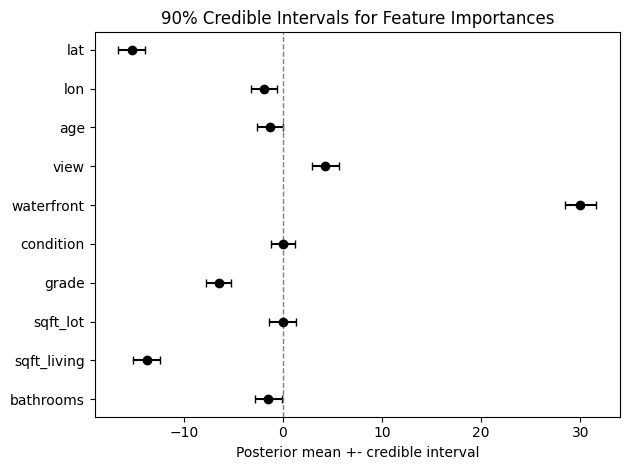

In [24]:
import matplotlib.pyplot as plt
blr = explanation["blr"]
creds = blr.creds # half width of credible intervals

# Lower and upper bounds
lower = means - creds
upper = means + creds
print(lower)

# Plot
plt.figure()
plt.errorbar(
    x = means,
    y = feature_names,
    xerr = [means - lower, upper - means],
    fmt = 'o', capsize=3, color='black'
)
plt.axvline(x=0, color='gray', linestyle='--', linewidth = 1)
plt.title(f"{blr.percent}% Credible Intervals for Feature Importances")
plt.xlabel("Posterior mean +- credible interval")
plt.tight_layout()
plt.show()

In [25]:
# Debugging
print(rf.predict(X_test.iloc[[test_index]]))
print(X_test.iloc[[test_index]]['lat'])
print(X_test.iloc[[test_index]]['sqft_living'])

[22.74410333]
316    47.4852
Name: lat, dtype: float64
316    960
Name: sqft_living, dtype: int64


c:\Rena\MIT2\UROP\SCR\project\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
